In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm
import seaborn as sns
import numpy as np
import pandas as pd
import pdal
import ipyvolume.pylab as p3

import glob
import json
import os
import scipy
from sklearn.cluster import DBSCAN

import rasterio 
from rasterio.plot import show
from rasterio.plot import show_hist

%matplotlib inline

In [2]:
### Due to the heavy data, this process takes a while to execute and it might craches

In [ ]:
# experiemnt for R code:
json = u'''
{
  "pipeline":[
    "./output_lidar/merged_lidar.laz",
    {
    "type":"filters.assign","assignment":"NumberOfReturns[:]=1"
    },
    {
    "type":"filters.assign","assignment":"ReturnNumber[:]=1"
    },
    {
        "type":"writers.las",
        "filename":"./input_lidar/merged_lidar_nr.laz"
    }
  ]
}'''
p_dsm = pdal.Pipeline(json)
p_dsm.validate()
count_dsm = p_dsm.execute()

In [3]:
json = u'''
{
  "pipeline":[
    "./output_lidar/merged_lidar_nr_10percent.laz"
  ]
}'''

In [4]:
p = pdal.Pipeline(json)
p.validate() # check if our JSON and options were good
p.loglevel = 8 #really noisy
count = p.execute()
data = p.arrays[0]
metadata = p.metadata
log = p.log
print('Read', count, 'points with', len(data.dtype), 'dimensions')
print('Dimension names are', data.dtype.names)

Read 1192732 points with 16 dimensions
Dimension names are ('X', 'Y', 'Z', 'Intensity', 'ReturnNumber', 'NumberOfReturns', 'ScanDirectionFlag', 'EdgeOfFlightLine', 'Classification', 'ScanAngleRank', 'UserData', 'PointSourceId', 'GpsTime', 'Red', 'Green', 'Blue')


##### With this pipeline we add a noise filter "filters.elm": The Extended Local Minimum (ELM) filter marks low points as noise. An outlier filter To remove the noise points altogether by adding a range filter "filters.range" (by applying a classification value of 7 to the noise points) to the pipeline, downstream from the outlier filter. A Simple Morphological Filter (SMRF) to segment ground (Classification=2) and non-ground (Classification=1). A Height Above Ground (HAG) filter is applied to estimate each point's height above ground. and finally an eignvalue filter which returns the eigenvalues for a given point, based on its k-nearest neighbors. The filter produces three new dimensions (Eigenvalue0, Eigenvalue1, and Eigenvalue2) which will be used later on segment the trees and the buildings based.

In [5]:
json = u'''
{
  "pipeline":[
    "./output_lidar/merged_lidar_nr_10percent.laz",
    {
    "type":"filters.elm",
    "threshold":2.0
    },
    {
    "type": "filters.outlier"
    },
    {
    "type":"filters.smrf"
    },
    {
    "type":"filters.hag"
    },
    {
    "type":"filters.eigenvalues",
    "knn":8
    }
  ]
}'''

pdal_All = pdal.Pipeline(json)
pdal_All .validate()
count_All = pdal_All .execute()
All_lidar = pdal_All .arrays[0]

Text(0, 0.5, 'Frequency')

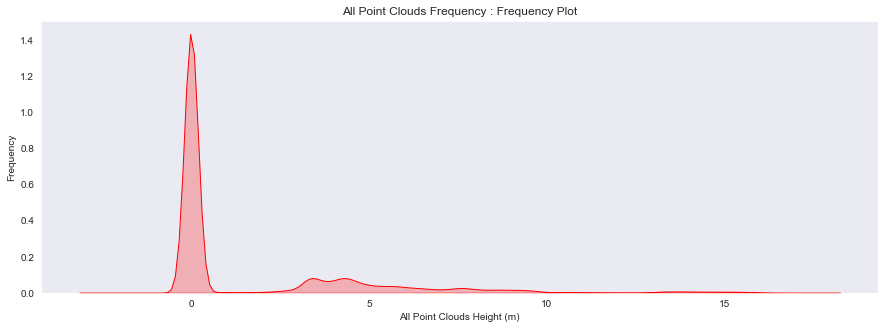

In [6]:
sns.set_style("dark")
plt.figure(figsize=(15,5)) 

sns.kdeplot(All_lidar['HeightAboveGround'], shade=True, color="r")
plt.title("All Point Clouds Frequency : Frequency Plot")
plt.xlabel("All Point Clouds Height (m)")
plt.ylabel("Frequency")

C:\Users\hp\anaconda3\envs\pdalenv\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Frequency')

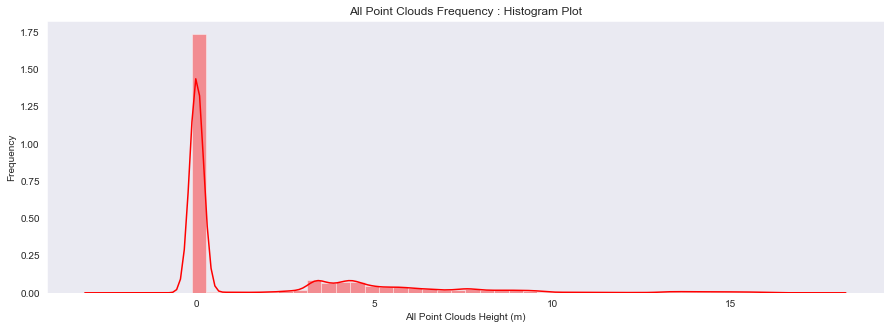

In [7]:
plt.figure(figsize=(15,5)) 

sns.distplot(All_lidar['HeightAboveGround'], color="r")
plt.title("All Point Clouds Frequency : Histogram Plot")
plt.xlabel("All Point Clouds Height (m)")
plt.ylabel("Frequency")

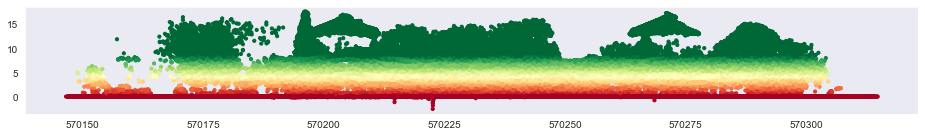

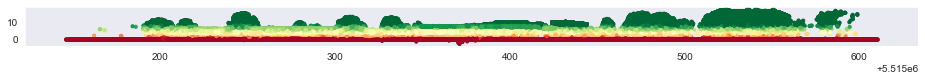

In [8]:
## Lets see the errors Point Clouds:
fig = plt.figure(figsize=(16,8))
ax = plt.axes(aspect='equal')
ax.scatter(All_lidar['X'],All_lidar['HeightAboveGround'],c=All_lidar['HeightAboveGround'],
           vmin=np.percentile(All_lidar['HeightAboveGround'],5),
           vmax=np.percentile(All_lidar['HeightAboveGround'],95),
           cmap='RdYlGn', s=10)

fig = plt.figure(figsize=(16,8))
ax = plt.axes(aspect='equal')
ax.scatter(All_lidar['Y'],All_lidar['HeightAboveGround'],c=All_lidar['HeightAboveGround'],
           vmin=np.percentile(All_lidar['HeightAboveGround'],5),
           vmax=np.percentile(All_lidar['HeightAboveGround'],95),
           cmap='RdYlGn', s=10)

### Visualizing the Height Above the Ground of only the non-ground Point Clouds
Lets segment the non-ground (Classification=1)

In [9]:
json = u'''
{
  "pipeline":[
    "./output_lidar/merged_lidar_nr_10percent.laz",
     {
    "type":"filters.elm",
    "threshold":2.0
    },
    {
    "type": "filters.outlier"
    },
    {
    "type":"filters.smrf"
    },
    {
    "type":"filters.hag"
    },
    {
      "type":"filters.range",
      "limits":"Classification[1:1]"
    },
    {
    "type":"filters.eigenvalues",
    "knn":8
    }
  ]
}'''

pdal_NG = pdal.Pipeline(json)
pdal_NG.validate()
count_NG = pdal_NG.execute()
NG_lidar = pdal_NG.arrays[0]

Text(0, 0.5, 'Frequency')

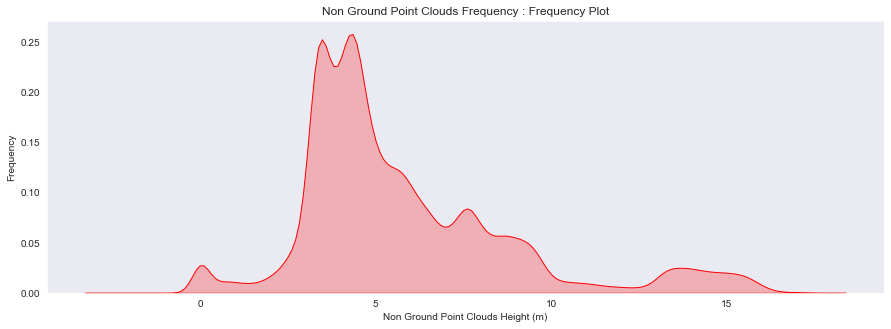

In [10]:
plt.figure(figsize=(15,5)) 

sns.kdeplot(NG_lidar['HeightAboveGround'], shade=True, color="r")
plt.title("Non Ground Point Clouds Frequency : Frequency Plot")
plt.xlabel("Non Ground Point Clouds Height (m)")
plt.ylabel("Frequency")

C:\Users\hp\anaconda3\envs\pdalenv\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Frequency')

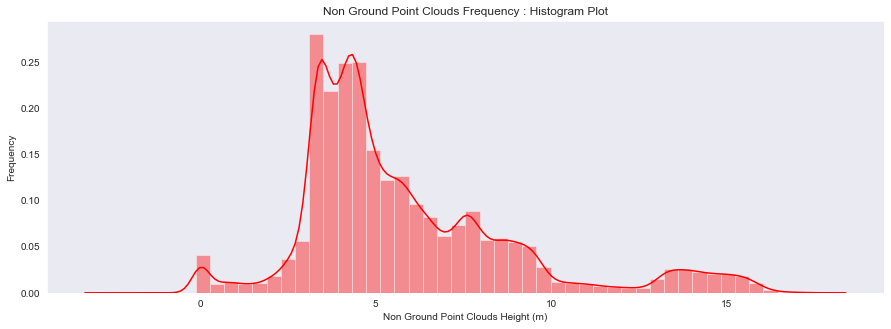

In [11]:
plt.figure(figsize=(15,5)) 

sns.distplot(NG_lidar['HeightAboveGround'],kde=True, color="r")
plt.title("Non Ground Point Clouds Frequency : Histogram Plot")
plt.xlabel("Non Ground Point Clouds Height (m)")
plt.ylabel("Frequency")

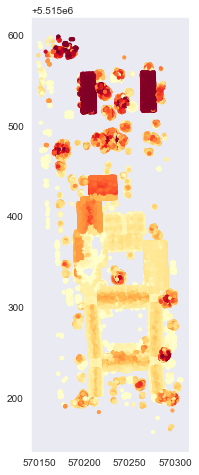

In [12]:
fig = plt.figure(figsize=(16,8))
ax = plt.axes(aspect='equal')
ax.scatter(NG_lidar['X'],NG_lidar['Y'],c=NG_lidar['HeightAboveGround'],
           vmin=np.percentile(NG_lidar['HeightAboveGround'],5),
           vmax=np.percentile(NG_lidar['HeightAboveGround'],95),
           cmap='YlOrRd', s=10)

#### Generate The Digital Surface Model: DSM

In [13]:
json = u'''
{
  "pipeline":[
    "./output_lidar/merged_lidar_nr_10percent.laz",
     {
    "type":"filters.elm",
    "threshold":2.0
    },
    {
    "type": "filters.outlier"
    },
    {
    "type":"filters.smrf"
    },
    {
    "type":"filters.hag"
    },
    {
      "type":"filters.range",
      "limits":"Classification[1:1]"
    },
    {
    "type":"writers.gdal",
    "filename":"./output_lidar/dsm_pdl.tif",
    "output_type":"mean",
    "gdaldriver":"GTiff",
    "resolution":0.1
    }
  ]
}'''
p_dsm = pdal.Pipeline(json)
p_dsm.validate()
count_dsm = p_dsm.execute()

In [14]:
raster_dsm = rasterio.open("./output_lidar/dsm_pdl.tif")
type(raster_dsm)

rasterio.io.DatasetReader

In [15]:
raster_dsm.profile

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': -9999.0, 'width': 1583, 'height': 4367, 'count': 1, 'crs': CRS.from_epsg(32632), 'transform': Affine(0.1, 0.0, 570148.93,
       0.0, -0.1, 5515598.800000001), 'tiled': False, 'interleave': 'band'}

In [16]:
print('CRS: ',raster_dsm.crs)

# Affine transform (how raster is scaled, rotated, skewed, and/or translated)
print('Transform: ',raster_dsm.transform)

# Dimensions
print('Width: ',raster_dsm.width)
print('Height: ',raster_dsm.height)

# Number of bands
print('Bands: ',raster_dsm.count)

# resolution 
print("image rsolution: ", raster_dsm.res)

# Bounds of the file
print('Boundary: ',raster_dsm.bounds)

# Driver (data format)
print('Driver: ', raster_dsm.driver)

# No data values for all channels
print('NoData: ', raster_dsm.nodatavals)

# All Metadata for the whole raster dataset
print('Metdata: ', raster_dsm.meta)

CRS:  EPSG:32632
Transform:  | 0.10, 0.00, 570148.93|
| 0.00,-0.10, 5515598.80|
| 0.00, 0.00, 1.00|
Width:  1583
Height:  4367
Bands:  1
image rsolution:  (0.1, 0.1)
Boundary:  BoundingBox(left=570148.93, bottom=5515162.100000001, right=570307.2300000001, top=5515598.800000001)
Driver:  GTiff
NoData:  (-9999.0,)
Metdata:  {'driver': 'GTiff', 'dtype': 'float64', 'nodata': -9999.0, 'width': 1583, 'height': 4367, 'count': 1, 'crs': CRS.from_epsg(32632), 'transform': Affine(0.1, 0.0, 570148.93,
       0.0, -0.1, 5515598.800000001)}


In [57]:
with rasterio.open("./output_lidar/dsm_pdl.tif") as src:
    wurz_dsm = src.read(1, masked= True)
    transform = src.transform

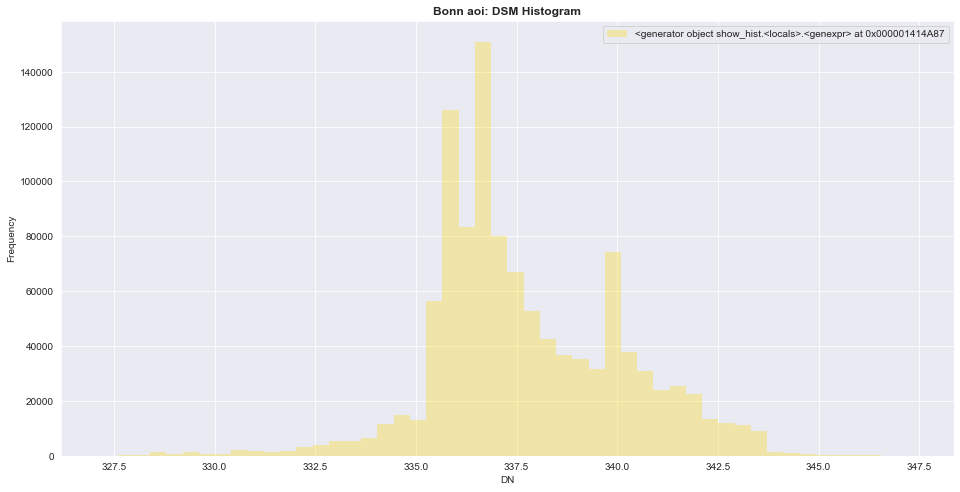

In [19]:
fig, ax = plt.subplots(figsize = (16,8))    

show_hist(wurz_dsm , bins=50, lw=0.0, stacked=False, alpha=0.3,
          histtype='stepfilled', title="Bonn aoi: DSM Histogram")

## Visualizing the Ground Point Clouds

Here we segment the ground (Classification=2)

In [20]:
json = u'''
{
  "pipeline":[
    "./output_lidar/merged_lidar_nr_10percent.laz",
     {
    "type":"filters.elm",
    "threshold":2.0
    },
    {
    "type": "filters.outlier"
    },
    {
    "type":"filters.smrf"
    },
    {
      "type":"filters.hag"
    },
    {
      "type":"filters.range",
      "limits":"Classification[2:2]"
    },
    {
    "type":"filters.eigenvalues",
    "knn":8
}
  ]
}'''

pdal_G = pdal.Pipeline(json)
pdal_G.validate()
count_G = pdal_G.execute()
G_lidar = pdal_G.arrays[0]

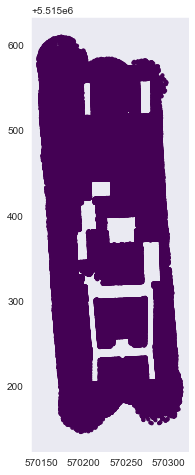

In [21]:
fig = plt.figure(figsize=(16,8))
sns.set_style("dark")
ax = plt.axes(aspect='equal')
ax.scatter(G_lidar['X'],G_lidar['Y'],c=G_lidar['HeightAboveGround'],
           vmin=np.percentile(G_lidar['HeightAboveGround'],5),
           vmax=np.percentile(G_lidar['HeightAboveGround'],95),
           cmap='viridis', s=10)

#### Generate The Digital Terrain Model: DTM

In [22]:
json = u'''
{
  "pipeline":[
    "./output_lidar/merged_lidar_nr_10percent.laz",
    {
    "type":"filters.elm",
    "threshold":2.0
    },
    {
    "type": "filters.outlier"
    },
    {
    "type":"filters.smrf"
    },
    {
      "type":"filters.hag"
    },
    {
    "type":"filters.range",
    "limits":"Classification[2:2]"
    },
    {
    "type":"writers.gdal",
    "filename":"./output_lidar/dtm_pdal.tif",
    "output_type":"min",
    "gdaldriver":"GTiff",
    "window_size":3,
    "resolution":0.1
    }
  ]
}'''
p_DTM = pdal.Pipeline(json)
p_DTM.validate()
count = p_DTM.execute()

In [23]:
raster_DTM = rasterio.open("./output_lidar/dtm_pdal.tif")
type(raster_DTM)

rasterio.io.DatasetReader

In [24]:
raster_DTM.profile

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': -9999.0, 'width': 1683, 'height': 4644, 'count': 1, 'crs': CRS.from_epsg(32632), 'transform': Affine(0.1, 0.0, 570146.5700000001,
       0.0, -0.1, 5515610.430000001), 'tiled': False, 'interleave': 'band'}

In [25]:
# Projection
print('CRS: ',raster_DTM.crs)

# Affine transform (how raster is scaled, rotated, skewed, and/or translated)
print('Transform: ',raster_DTM.transform)

# Dimensions
print('Width: ',raster_DTM.width)
print('Height: ',raster_DTM.height)

# Number of bands
print('Bands: ',raster_DTM.count)

# resolution 
print("image rsolution: ", raster_DTM.res)

# Bounds of the file
print('Boundary: ',raster_DTM.bounds)

# Driver (data format)
print('Driver: ', raster_DTM.driver)

# No data values for all channels
print('NoData: ', raster_DTM.nodatavals)

# All Metadata for the whole raster dataset
print('Metdata: ',raster_DTM.meta)

CRS:  EPSG:32632
Transform:  | 0.10, 0.00, 570146.57|
| 0.00,-0.10, 5515610.43|
| 0.00, 0.00, 1.00|
Width:  1683
Height:  4644
Bands:  1
image rsolution:  (0.1, 0.1)
Boundary:  BoundingBox(left=570146.5700000001, bottom=5515146.03, right=570314.8700000001, top=5515610.430000001)
Driver:  GTiff
NoData:  (-9999.0,)
Metdata:  {'driver': 'GTiff', 'dtype': 'float64', 'nodata': -9999.0, 'width': 1683, 'height': 4644, 'count': 1, 'crs': CRS.from_epsg(32632), 'transform': Affine(0.1, 0.0, 570146.5700000001,
       0.0, -0.1, 5515610.430000001)}


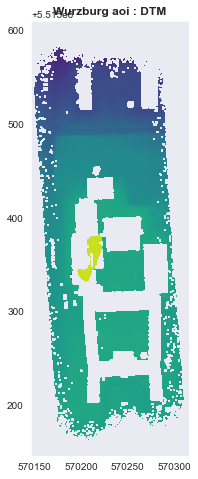

<AxesSubplot:title={'center':'Wurzburg aoi : DTM'}>

In [26]:
with rasterio.open("./output_lidar/dtm_pdal.tif") as src:
    wurz_DTM = src.read(1, masked= True)
    transform = src.transform

fig, ax = plt.subplots(figsize = (16,8))    
show(wurz_DTM, cmap='viridis', transform=transform,title="Wurzburg aoi : DTM")

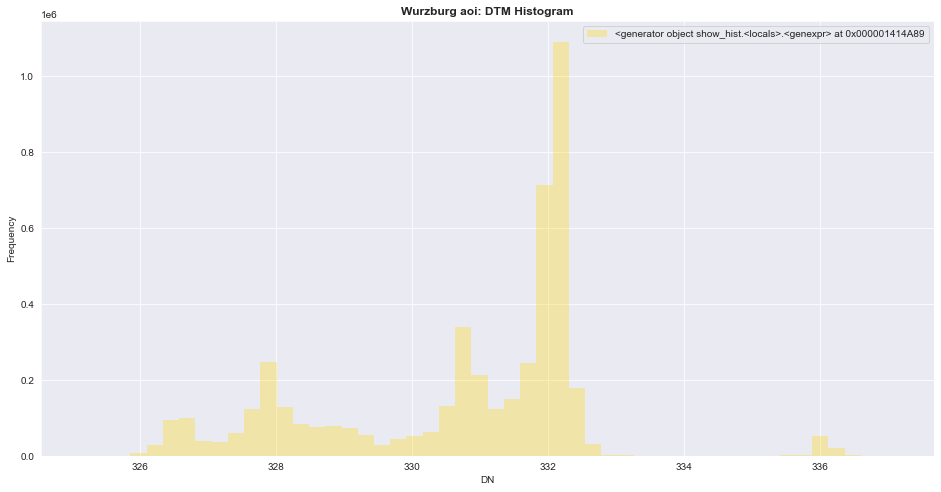

In [27]:
fig, ax = plt.subplots(figsize = (16,8))    

show_hist(wurz_DTM , bins=50, lw=0.0, stacked=False, alpha=0.3,
          histtype='stepfilled', title="Wurzburg aoi: DTM Histogram")

## Visualizing the Point Clouds in 3D

In [ ]:
## 1. Visualizing all point clouds

In [28]:
def return_df (type_lidar,df_name):
    '''return the pipline processing output as a data frame
    Args:
         type_lidar: either ground "G", non ground "NG", or combination "All"
         df: dataframe name
    
    '''
    inf = type_lidar.dtype.descr
    cols = [col for col, __ in inf ]
    
    df = pd.DataFrame({col: type_lidar[col] for col in cols})
    df['X_0'] = df['X']
    df['Y_0'] = df['Y']
    df['Z_0'] = df['Z']
    df['X'] = df['X'] - df['X_0'].min()
    df['Y'] = df['Y'] - df['Y_0'].min()
    df['Z'] = df['Z'] - df['Z_0'].min()
    df.name = df_name
    return df

def viz_ldpy (df, colour):
    ''' Viz the data frame in a 3D according to the X, Y and Z
    Args:
         type_lidar: either ground "G", non ground "NG", or combination "All"
         df: dataframe name
    
    '''
    fig = p3.figure(width=1000) 
    fig.xlabel='Y'
    fig.ylabel='Z'
    fig.zlabel='X'
    Points = p3.scatter(df['Y'], df['Z'], df['X'], color= colour, size=.2)
    p3.squarelim()
    p3.show()

In [29]:
DF = return_df (All_lidar,"DF")

In [30]:
DF.head()

,X,Y,Z,Intensity,ReturnNumber,NumberOfReturns,ScanDirectionFlag,EdgeOfFlightLine,Classification,ScanAngleRank,...,Red,Green,Blue,HeightAboveGround,Eigenvalue0,Eigenvalue1,Eigenvalue2,X_0,Y_0,Z_0
0,28.93,15.99,7.39,0,1,1,0,0,2,0.0,...,0,0,0,0.0,0.000192,0.040592,0.868552,570175.50,5515162.02,332.53
1,29.34,13.95,7.48,0,1,1,0,0,2,0.0,...,0,0,0,0.0,0.000331,0.151560,1.081775,570175.91,5515159.98,332.62
2,29.85,13.63,7.54,0,1,1,0,0,2,0.0,...,0,0,0,0.0,0.000331,0.151560,1.081775,570176.42,5515159.66,332.68
3,29.27,15.19,7.43,0,1,1,0,0,2,0.0,...,0,0,0,0.0,0.000164,0.027142,0.865707,570175.84,5515161.22,332.57
4,29.66,14.26,7.53,0,1,1,0,0,2,0.0,...,0,0,0,0.0,0.000331,0.151560,1.081775,570176.23,5515160.29,332.67


In [31]:
viz_ldpy(DF,"red")

In [ ]:
## 2. the point cloud data classified as non Ground

In [32]:
DF_NG = return_df(NG_lidar,"DF_NG")

In [33]:
DF_NG.head()

,X,Y,Z,Intensity,ReturnNumber,NumberOfReturns,ScanDirectionFlag,EdgeOfFlightLine,Classification,ScanAngleRank,...,Red,Green,Blue,HeightAboveGround,Eigenvalue0,Eigenvalue1,Eigenvalue2,X_0,Y_0,Z_0
0,25.82,39.37,5.49,0,1,1,0,0,1,0.0,...,0,0,0,0.58,0.041297,0.085585,0.341602,570174.75,5515201.47,332.68
1,24.80,45.05,5.65,0,1,1,0,0,1,0.0,...,0,0,0,0.73,0.019949,0.117706,0.254008,570173.73,5515207.15,332.84
2,25.80,81.44,5.28,0,1,1,0,0,1,0.0,...,0,0,0,0.47,0.053018,0.060047,74.071455,570174.73,5515243.54,332.47
3,25.94,81.41,5.30,0,1,1,0,0,1,0.0,...,0,0,0,0.61,0.053018,0.060047,74.071455,570174.87,5515243.51,332.49
4,26.66,81.79,5.58,0,1,1,0,0,1,0.0,...,0,0,0,0.78,0.053018,0.060047,74.071455,570175.59,5515243.89,332.77


In [34]:
## Viz the highest data
DF_NG.sort_values(by='HeightAboveGround',ascending=False).head() # the heighest Point clouds is about 18m

,X,Y,Z,Intensity,ReturnNumber,NumberOfReturns,ScanDirectionFlag,EdgeOfFlightLine,Classification,ScanAngleRank,...,Red,Green,Blue,HeightAboveGround,Eigenvalue0,Eigenvalue1,Eigenvalue2,X_0,Y_0,Z_0
50697,47.28,379.04,18.39,0,1,1,0,0,1,0.0,...,0,0,0,17.66,0.028137,0.059793,0.117616,570196.21,5515541.14,345.58
323641,47.01,378.95,18.22,0,1,1,0,0,1,0.0,...,0,0,0,17.59,0.016584,0.063934,0.121096,570195.94,5515541.05,345.41
50721,47.26,378.61,18.06,0,1,1,0,0,1,0.0,...,0,0,0,17.43,0.030052,0.047655,0.134313,570196.19,5515540.71,345.25
50705,47.58,374.14,18.06,0,1,1,0,0,1,0.0,...,0,0,0,17.43,0.002359,0.006324,0.016539,570196.51,5515536.24,345.25
50706,47.09,388.68,18.11,0,1,1,0,0,1,0.0,...,0,0,0,17.42,0.008145,0.044683,0.061292,570196.02,5515550.78,345.30


In [35]:
viz_ldpy(DF_NG,"red")

In [ ]:
## 3. the point cloud data classified as Ground

In [36]:
DF_G = return_df(G_lidar,"DF_NG")

In [37]:
DF_G.head()

,X,Y,Z,Intensity,ReturnNumber,NumberOfReturns,ScanDirectionFlag,EdgeOfFlightLine,Classification,ScanAngleRank,...,Red,Green,Blue,HeightAboveGround,Eigenvalue0,Eigenvalue1,Eigenvalue2,X_0,Y_0,Z_0
0,28.93,15.99,7.39,0,1,1,0,0,2,0.0,...,0,0,0,0.0,0.000192,0.040592,0.868552,570175.50,5515162.02,332.53
1,29.34,13.95,7.48,0,1,1,0,0,2,0.0,...,0,0,0,0.0,0.000331,0.151560,1.081775,570175.91,5515159.98,332.62
2,29.85,13.63,7.54,0,1,1,0,0,2,0.0,...,0,0,0,0.0,0.000331,0.151560,1.081775,570176.42,5515159.66,332.68
3,29.27,15.19,7.43,0,1,1,0,0,2,0.0,...,0,0,0,0.0,0.000164,0.027142,0.865707,570175.84,5515161.22,332.57
4,29.66,14.26,7.53,0,1,1,0,0,2,0.0,...,0,0,0,0.0,0.000331,0.151560,1.081775,570176.23,5515160.29,332.67


In [38]:
viz_ldpy(DF_G,"lightgrey")

In [ ]:
## 4. Lets visualize the Ground and non ground in one plot

In [39]:
fig = p3.figure(width=1000)

# Define all points and ground points for plot
NonGround = p3.scatter(DF_NG['Y'], DF_NG['Z'], DF_NG['X'], color='red', size=.2)
Ground= p3.scatter(DF_G['Y'], DF_G['Z'], DF_G['X'], color='lightgrey', size=.2)

# Add labels to plot
fig.xlabel='Y'
fig.ylabel='Z'
fig.zlabel='X'

# Append both sets of points to plot
fig.scatters.append(NonGround)
fig.scatters.append(Ground)

p3.squarelim()
p3.show()

### Potential Segmentation of Lidar Data: Buildings and Trees!

In [49]:
fig = p3.figure(width=1000)
fig.xlabel='Y'
fig.ylabel='Z'
fig.zlabel='X'
all_points = p3.scatter(DF['Y'], DF['Z'], DF['X'], color='red', size=.2)
p3.squarelim()
p3.show()

In [50]:
# Color ground in grey
DF['ground'] = DF['Classification'] == 2

ground = p3.scatter(DF.loc[DF['ground'],'Y'].values, DF.loc[DF['ground'],'Z'].values, DF.loc[DF['ground'],'X'].values, color='red', size=.2)
non_ground = p3.scatter(DF.loc[~DF['ground'],'Y'].values, DF.loc[~DF['ground'],'Z'].values, DF.loc[~DF['ground'],'X'].values, color='red', size=.2)

fig.scatters.append(ground)
fig.scatters.append(non_ground)

all_points.visible = False
ground.color='lightgrey'

In [51]:
# Visualize the Ground as surface
ground_delaunay = scipy.spatial.Delaunay(DF.loc[DF['ground'],['X','Y']])
ground_surf = p3.plot_trisurf(DF.loc[DF['ground'],'Y'], DF.loc[DF['ground'],'Z'], DF.loc[DF['ground'],'X'], ground_delaunay.simplices, color='lightgrey')
fig.meshes.append(ground_surf)
ground.visible=False

In [52]:
# Color points according to flatness
DF['Flatness'] = DF['Eigenvalue0'] 
non_ground.color=matplotlib.cm.RdYlGn(DF.loc[~DF['ground'],'Flatness']*4)[:,0:3]

In [53]:
# Separate between trees and the rest
DF['tree_potential'] = (DF['Classification']==1) & (DF['HeightAboveGround'] >= 2) & (DF['Flatness'] > .05) &  (DF['NumberOfReturns'] - DF['ReturnNumber'] >= 1) 
DF['other'] = ~DF['ground'] & ~DF['tree_potential']

In [54]:
tree_potential = p3.scatter(DF.loc[DF['tree_potential'],'Y'].values, DF.loc[DF['tree_potential'],'Z'].values, DF.loc[DF['tree_potential'],'X'].values, color=matplotlib.cm.RdYlGn(DF.loc[DF['tree_potential'],'Flatness']*4)[:,0:3], size=.2)
other = p3.scatter(DF.loc[DF['other'],'Y'].values, DF.loc[DF['other'],'Z'].values, DF.loc[DF['other'],'X'].values, color=matplotlib.cm.RdYlGn(DF.loc[DF['other'],'Flatness']*4)[:,0:3], size=.2)
non_ground.visible=False
tree_potential.color='darkgreen'
other.color='red'

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
# Unexpected error!?

### Pipeline for segmentation using Approximate Coplanar Filter (Algorithm of [Limberger2015])

In [58]:
json = u'''
{
  "pipeline":[
    "./output_lidar/merged_lidar_nr_10percent.laz",
    {
    "type":"filters.elm",
    "threshold":2.0
    },
    {
    "type": "filters.outlier"
    },
    {
    "type":"filters.smrf"
    },
    {
    "type":"filters.hag"
    },
    {
        "type":"filters.approximatecoplanar",
        "knn":64,
        "thresh1":25,
        "thresh2":6
    },
    {
        "type":"filters.range",
        "limits":"Coplanar[1:1]"
    },
    "./output_lidar/Segmentation_pdal.laz"
  ]
}'''

pdal_seg = pdal.Pipeline(json)
pdal_seg .validate()
count_seg = pdal_seg .execute()

In [60]:
seg_lidar = pdal_seg.arrays[0]
seg_lidar 

array([(570175.5 , 5515162.02, 332.53, 0, 1, 1, 0, 0, 2, 0., 0, 0, 0., 0, 0, 0, 0.  , 1),
       (570175.91, 5515159.98, 332.62, 0, 1, 1, 0, 0, 2, 0., 0, 0, 0., 0, 0, 0, 0.  , 1),
       (570176.42, 5515159.66, 332.68, 0, 1, 1, 0, 0, 2, 0., 0, 0, 0., 0, 0, 0, 0.  , 1),
       ...,
       (570221.04, 5515421.04, 338.76, 0, 1, 1, 0, 0, 1, 0., 0, 0, 0., 0, 0, 0, 6.09, 1),
       (570221.55, 5515425.33, 342.02, 0, 1, 1, 0, 0, 1, 0., 0, 0, 0., 0, 0, 0, 9.6 , 1),
       (570221.38, 5515439.54, 340.23, 0, 1, 1, 0, 0, 1, 0., 0, 0, 0., 0, 0, 0, 9.  , 1)],
      dtype=[('X', '<f8'), ('Y', '<f8'), ('Z', '<f8'), ('Intensity', '<u2'), ('ReturnNumber', 'u1'), ('NumberOfReturns', 'u1'), ('ScanDirectionFlag', 'u1'), ('EdgeOfFlightLine', 'u1'), ('Classification', 'u1'), ('ScanAngleRank', '<f4'), ('UserData', 'u1'), ('PointSourceId', '<u2'), ('GpsTime', '<f8'), ('Red', '<u2'), ('Green', '<u2'), ('Blue', '<u2'), ('HeightAboveGround', '<f8'), ('Coplanar', 'u1')])